# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
import pycaret
from pycaret.classification import *
from sklearn import metrics
from imblearn.over_sampling import *

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [20]:
def clean_data(df):
    '''
    This function clears the columns and rows of the dataframes of this analysis.
    input: df
    output: df_clean
    '''
    #Clean columns with no context
    drop_context = ['LNR', 'AKT_DAT_KL', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
     'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_INTL_2015', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 
     'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 
     'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 
     'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 
     'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 
     'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 
     'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_MOBILE', 
     'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_REST', 
     'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_VERSICHERUNGEN', 'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 
     'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992', 'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1', 
     'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_CCM_1401_2500', 'KBA13_CCM_3000', 'KBA13_CCM_3001', 'KBA13_GBZ', 
     'KBA13_HHZ', 'KBA13_KMH_210', 'KK_KUNDENTYP', 'KOMBIALTER', 'KONSUMZELLE', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 
     'RT_UEBERGROESSE', 'SOHO_KZ', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA', 'VHN', 
     'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11']
    df = df.drop(columns = drop_context)


    #Clean columns
    drop_columns = ['D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_VERSAND_ONLINE_QUOTE_12']
    df = df.drop(columns = drop_columns)
    
    #Clean rows
    df_mv_r = df.isnull().sum(axis = 1)/df.shape[1]
    df_row_threshold = 0.1
    df = df[df_mv_r <= df_row_threshold]
    
    #Categorical collumns
    df = df.drop(columns = ['CAMEO_DEU_2015'])
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', -1)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    
    to_dummy = 'OST_WEST_KZ'
    dummy = pd.get_dummies(df[to_dummy])
    df.drop(to_dummy, axis=1, inplace=True)
    df = pd.concat([df, dummy], axis=1)
    
    #Nan to -1
    df = df.fillna(value= -1)
    
    #Drop KBA columns
    #kba_cols = df.columns[df.columns.str.startswith('KBA')]
    #df = df.drop(columns = kba_cols)
    
    return df

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [23]:
mail_train = pd.read_csv('mail_train.csv', sep=';', index_col = 'Unnamed: 0')
mail_test = pd.read_csv('mail_test.csv', sep=';', index_col = 'Unnamed: 0')

First we will create a backup of the bases in case it is necessary to revisit some data.

In [24]:
mail_train_bkp = mail_train
mail_test_bkp = mail_test

Next, we will use the clean_data function created earlier to clean the base and prepare it for the Supervised Learning Models algorithms

In [25]:
mail_train = clean_data(mail_train)
mail_test = clean_data(mail_test)

In [26]:
#Testing if everything is ok
print('mail_train original:', mail_train_bkp.shape)
print('mail_train cleaned:', mail_train.shape)

print('mail_test original:', mail_test_bkp.shape)
print('mail_test cleaned:', mail_test.shape)

mail_train original: (42962, 367)
mail_train cleaned: (34214, 261)
mail_test original: (42833, 366)
mail_test cleaned: (34177, 260)


Before we start the creation we need to understand the class balance.

0    33790
1      424
Name: RESPONSE, dtype: int64


<AxesSubplot:xlabel='RESPONSE', ylabel='count'>

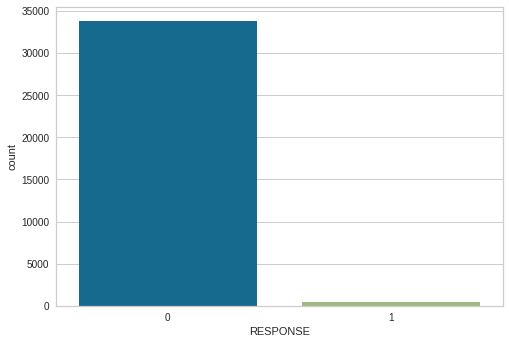

In [27]:
print(mail_train['RESPONSE'].value_counts())
sns.countplot('RESPONSE', data=mail_train)

To build the prediction model we will use the pycaret library. The choice for this library is due to the practicality of performing the setup and the ease of viewing the best models. The library also offers options for tuning the model and visualization tools. 

We start by configuring the training base target, the variables that will be used and the method to adjust the class imbalance.

In [28]:
target = 'RESPONSE'
variables = list(mail_train.columns.values)
variables.remove(target)
num_vars = variables
adasyn1 = ADASYN(sampling_strategy='minority')

In [29]:
#Setup do Pycaret
exp_setup = setup(data=mail_train, 
                  target=target,
                  numeric_features = num_vars,
                  use_gpu=True,
                  normalize=True,
                  remove_outliers = True,
                  fix_imbalance=True,
                  fix_imbalance_method= adasyn1,
                  remove_multicollinearity = True, 
                  multicollinearity_threshold = 0.8,
                  session_id=42) 

,Description,Value
0,session_id,42
1,Target,RESPONSE
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(34214, 261)"
5,Missing Values,False
6,Numeric Features,260
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=['AGER_TYP',
                                                          'ALTER_HH',
                                                          'ANZ_HAUSHALTE_AKTIV',
                                                          'ANZ_HH_TITEL',
                                                          'ANZ_PERSONEN',
                                                          'ANZ_TITEL', 'ARBEIT',
                                                          'BALLRAUM',
                                                         

Then we use compare_models to test 16 different models so we can decide which one makes the most sense for our reality.

In [30]:
best_model = compare_models(fold=5, sort='auc')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9875,0.5782,0.0000,0.0000,0.0000,0.0000,0.0000,4.598
lightgbm,Light Gradient Boosting Machine,0.9875,0.5693,0.0000,0.0000,0.0000,0.0000,0.0000,10.184
catboost,CatBoost Classifier,0.9875,0.5606,0.0000,0.0000,0.0000,0.0000,0.0000,77.110
lda,Linear Discriminant Analysis,0.7111,0.5597,0.3381,0.0148,0.0284,0.0046,0.0133,4.738
lr,Logistic Regression,0.7357,0.5587,0.3274,0.0158,0.0301,0.0064,0.0174,5.444
gbc,Gradient Boosting Classifier,0.9875,0.5521,0.0000,0.0000,0.0000,0.0000,0.0000,107.520
et,Extra Trees Classifier,0.9875,0.5352,0.0000,0.0000,0.0000,0.0000,0.0000,10.600
rf,Random Forest Classifier,0.9875,0.5317,0.0000,0.0000,0.0000,0.0000,0.0000,30.520
nb,Naive Bayes,0.4672,0.5237,0.5670,0.0132,0.0259,0.0015,0.0074,3.108
ada,Ada Boost Classifier,0.9687,0.5185,0.0316,0.0208,0.0246,0.0098,0.0101,23.242


INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 2
INFO:logs:XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0, ...)
INFO:logs:compare_models() succesfully completed......................................


To decide which models we will choose we need to think about the application. Our main objective is to send emails to users who are likely to respond to the communication. So, in addition to looking at AUC, we also need to consider Recall as an important metric. Among the available options, the Linear Discriminant Analysis algorithm showed the best performance, so it was chosen to proceed with the analysis.


In [31]:
bestmodel = 'lda'
bestmodel

'lda'

With that we create a model with Linear Discriminant Analysis

In [32]:
PredModel = create_model(bestmodel, fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7034,0.5821,0.3333,0.0143,0.0274,0.0034,0.0101
1,0.7066,0.5533,0.3571,0.0152,0.0291,0.0056,0.0165
2,0.7116,0.5643,0.3684,0.0162,0.0310,0.0072,0.0208
3,0.7073,0.5522,0.3158,0.0137,0.0263,0.0024,0.0069
4,0.7266,0.5467,0.3158,0.0147,0.0281,0.0043,0.0119
Mean,0.7111,0.5597,0.3381,0.0148,0.0284,0.0046,0.0133
Std,0.0082,0.0126,0.0214,0.0008,0.0016,0.0017,0.0049


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 3
INFO:logs:LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
INFO:logs:create_model() succesfully completed......................................


After creation we run the model through two rounds of tuning. The first with a fold of 5 and the second with a fold of 10.

In [33]:
PredModel_tune = tune_model(PredModel, fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7040,0.5826,0.3333,0.0143,0.0274,0.0035,0.0103
1,0.7064,0.5534,0.3571,0.0152,0.0291,0.0056,0.0165
2,0.7119,0.5645,0.3684,0.0162,0.0310,0.0072,0.0209
3,0.7079,0.5523,0.3158,0.0138,0.0264,0.0024,0.0070
4,0.7270,0.5468,0.3158,0.0147,0.0282,0.0043,0.0121
Mean,0.7114,0.5599,0.3381,0.0148,0.0284,0.0046,0.0133
Std,0.0082,0.0127,0.0214,0.0008,0.0016,0.0017,0.0048


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 4
INFO:logs:LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=0.001,
                           solver='eigen', store_covariance=False, tol=0.0001)
INFO:logs:tune_model() succesfully completed......................................


In [34]:
PredModel_tune = tune_model(PredModel, fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7021,0.6495,0.4483,0.0193,0.0369,0.0128,0.0377
1,0.6976,0.5267,0.3929,0.0161,0.0310,0.0075,0.0227
2,0.6927,0.5852,0.4286,0.0173,0.0332,0.0098,0.0298
3,0.7077,0.5949,0.3571,0.0152,0.0292,0.0057,0.0168
4,0.6993,0.6523,0.5714,0.0233,0.0447,0.0215,0.0654
5,0.7029,0.5067,0.2500,0.0106,0.0203,-0.0034,-0.0101
6,0.7165,0.5296,0.2857,0.0126,0.0242,0.0006,0.0019
7,0.6800,0.5769,0.4483,0.0179,0.0345,0.0102,0.0316
8,0.7125,0.5595,0.3103,0.0140,0.0268,0.0025,0.0070


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 5
INFO:logs:LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=0.05,
                           solver='lsqr', store_covariance=False, tol=0.0001)
INFO:logs:tune_model() succesfully completed......................................


To help evaluate the model, we print some analyses.

Starting with the ROC curve that shows the relationship between True Positive Rate and False Positive. By default, we used a threshold of 0.5 in the model.

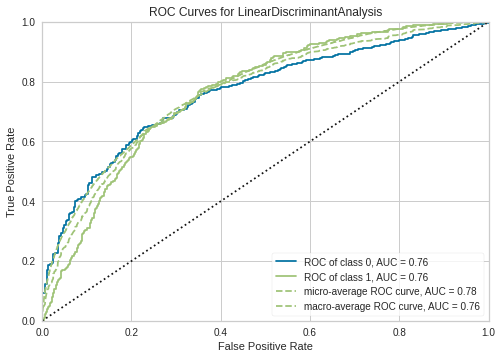

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [35]:
# nos dados de treino
plot_model(PredModel_tune, plot = 'auc', use_train_data=True)

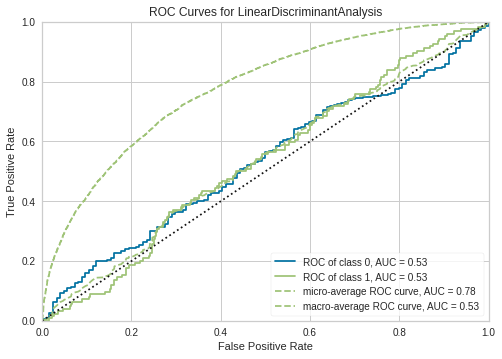

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [36]:
# nos dados de teste
plot_model(PredModel_tune, plot = 'auc', use_train_data=False)

We also analyze the features that most impact the model. We observed a lot of car-related featues (KBA). But we look at LP_STATUS_GROB in the third place which is related to social status.

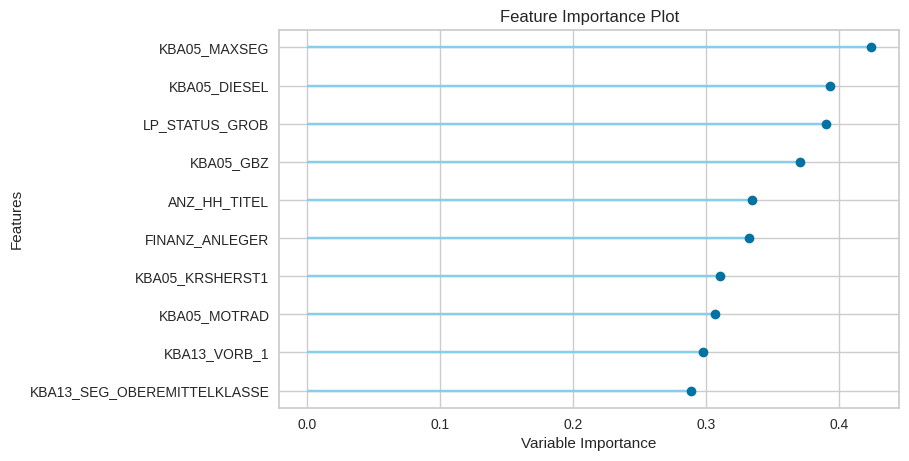

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [51]:
# nos dados de treino
plot_model(PredModel_tune, plot='feature', use_train_data=True)

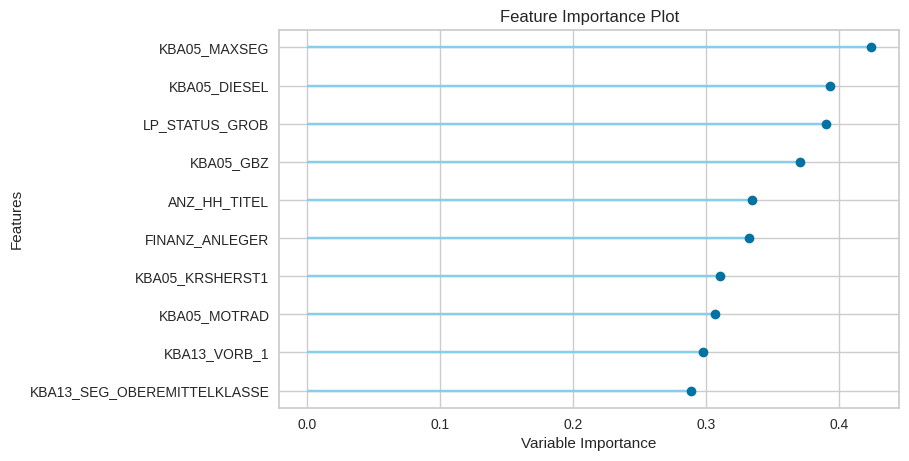

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [38]:
# nos dados de teste
plot_model(PredModel_tune, plot='feature', use_train_data=False)

In the confusion matrices, we observed that the results are acceptable, since True Positives are more than twice as many as False Positives and most of them are being classified as True Negatives.

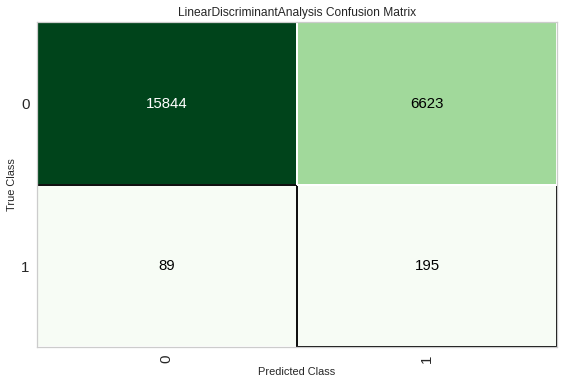

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [39]:
# nos dados de treino
plot_model(PredModel_tune, plot='confusion_matrix', use_train_data=True)

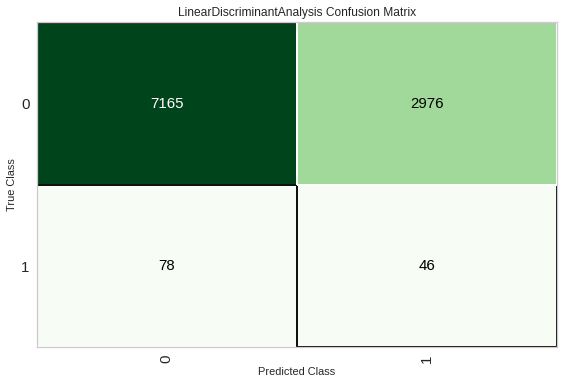

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [40]:
# nos dados de teste
plot_model(PredModel_tune, plot='confusion_matrix', use_train_data=False)

Finally, we print the model and save it to be able to use it in the prediction.

In [42]:
predict_model(PredModel_tune)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=0.05,
                           solver='lsqr', store_covariance=False, tol=0.0001), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.7025,0.5315,0.371,0.0152,0.0292,0.0062,0.0186


,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB,O,RESPONSE,Label,Score
0,0.866400,-0.374200,0.862181,-0.092721,-0.755264,-0.090770,0.908380,-1.470913,1.657533,0.116527,...,-0.833668,0.805332,0.249123,-0.023043,0.206246,0.590356,-0.560809,0,0,0.7831
1,-1.362962,-1.688715,-0.304921,-0.092721,-0.022192,-0.090770,-0.026305,1.255803,-0.392618,-0.512012,...,-0.833668,0.805332,0.249123,1.455133,0.206246,0.590356,1.783138,0,1,0.5812
2,1.609521,-0.538514,-0.304921,-0.092721,-0.755264,-0.090770,-0.026305,0.801350,-0.392618,-0.512012,...,-0.833668,0.805332,-0.811542,-1.008493,0.206246,-0.650293,-0.560809,0,1,0.5752
3,0.123279,-0.209885,-0.240082,-0.092721,-0.022192,-0.090770,-0.026305,-0.107555,-0.392618,-0.512012,...,-0.833668,0.805332,0.249123,-0.515768,0.206246,0.590356,-0.560809,0,0,0.7920
4,0.866400,-1.688715,-0.369760,-0.092721,-0.022192,-0.090770,-0.026305,-0.562008,-0.392618,2.002146,...,0.955998,-0.519925,0.249123,-0.515768,0.206246,0.590356,1.783138,0,0,0.7618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10260,0.123279,0.118744,-0.369760,-0.092721,-0.022192,-0.090770,0.908380,1.255803,-0.802648,-0.512012,...,-0.833668,0.805332,0.249123,-0.515768,1.024433,-0.650293,1.783138,1,0,0.7791
10261,0.123279,0.447372,-0.369760,-0.092721,-0.022192,-0.090770,-0.026305,0.801350,-0.392618,-0.512012,...,-0.833668,-1.403429,0.249123,1.455133,1.024433,-0.650293,-0.560809,0,0,0.5064
10262,-1.362962,0.283058,0.473147,2.532081,-0.022192,20.225666,0.908380,-1.470913,-1.622709,0.745067,...,-0.833668,0.805332,0.249123,-0.515768,0.206246,-1.890942,1.783138,0,0,0.9947
10263,-1.362962,1.433259,-0.240082,-0.092721,0.710880,-0.090770,-0.026305,-0.107555,0.427442,0.745067,...,-0.833668,-0.961677,0.249123,1.455133,0.206246,-0.650293,-0.560809,0,0,0.9837


In [43]:
final_model = finalize_model(PredModel_tune)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=0.05,
                           solver='lsqr', store_covariance=False, tol=0.0001), fit_kwargs=None, groups=None, model_only=True, display=None, experiment_custom_tags=None, return_train_score=False)
INFO:logs:Finalizing LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=0.05,
                           solver='lsqr', store_covariance=False, tol=0.0001)
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=0.05,
                           solver='lsqr', store_covariance=False, tol=0.0001), fold=None, round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=True, verbose=False, system=False, metrics=None, experiment_custom_tags=None, add_to_model_list=False, probability_threshold=None, display=None, return_train_score=F

### Prediction
With the model saved, we perform the test base prediction.

In [44]:
predictions = predict_model(final_model, data=mail_test)
predictions.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=0.05,
                           solver='lsqr', store_covariance=False, tol=0.0001), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,O,W,Label,Score
0,2,7.0,2.0,0.0,2.0,0.0,3.0,6.0,2.0,5.0,...,6.0,9.0,3.0,3,1,4,0,1,1,0.6949
1,-1,0.0,20.0,0.0,1.0,0.0,4.0,7.0,5.0,1.0,...,6.0,9.0,5.0,3,1,4,0,1,0,0.6501
2,2,16.0,2.0,0.0,4.0,0.0,4.0,1.0,7.0,2.0,...,2.0,9.0,4.0,3,2,4,0,1,0,0.7785
3,-1,0.0,1.0,0.0,0.0,0.0,4.0,1.0,2.0,4.0,...,-1.0,9.0,2.0,3,2,4,1,0,0,0.6978
4,1,21.0,1.0,0.0,4.0,0.0,3.0,6.0,5.0,6.0,...,3.0,9.0,7.0,4,2,4,0,1,0,0.8617


In [46]:
propensity = predictions[['Label','Score']][predictions['Label']==1]

In [54]:
print('Test base:', predictions.shape[0])
print('Test base with a propensity to respond:', propensity.shape[0])
print('Base percentage:', propensity.shape[0]/predictions.shape[0])

Test base: 34177
Test base with a propensity to respond: 11265
Base percentage: 0.329607630862861


By our prediction we arrived at the value of 11,265 people likely to respond, corresponding to 32.9% of the base. In other words, with the algorithm we were able to reduce the size of the base by two thirds, saving and optimizing the campaign budget.

Next, we have the distribution of the propensity score. We observed that most of the predictions have scores close to 0.5 and this value drops when approaching 1.

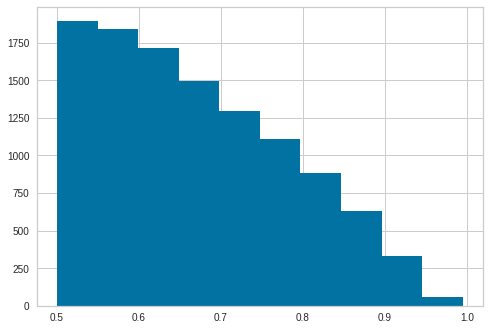

In [45]:
df_true = predictions[predictions['Label']==1]
plt.hist(df_true['Score'])
plt.show()